In [17]:
from media_processing.data_processor import DataProcessor, DataLoader

from model import *
import torch.optim as optim
import torch.nn as nn
import torch

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [18]:
def metric(output, target):
    pred = (output > 0.5).float()
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_item(loss_func, output, target, optimizer=None):
    loss_value = loss_func(output, target)

    metric_value = metric(output, target)

    if optimizer is not None:
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
    
    return loss_value.item(), metric_value / target.shape[0]

def loss_epoch(model, loss_func, data_loader, device, optimizer=None):

    running_loss = 0.0
    running_metric = 0.0
    
    for markers, video, audio in tqdm(data_loader, desc='Predicting Videos', unit='video'):
        video, audio, markers = video.to(device), audio.to(device), markers.to(device)
        model_output = model(video, audio)

        loss_value, metric_value = loss_item(loss_func, model_output, markers, optimizer)

        running_loss += loss_value
        running_metric += metric_value
            
    average_loss = running_loss / len(data_loader)
    average_metric = running_metric / len(data_loader)

    return average_loss, average_metric

In [19]:
def save_model(model):
    model_dir = os.path.join(os.getcwd(), 'data', 'models')
    os.makedirs(model_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(model_dir, 'model_.pth'))

def load_model(name):
    model_dir = os.path.join(os.getcwd(), 'data', 'models')
    model = Net_v2_Improved()
    model.load_state_dict(torch.load(os.path.join(model_dir, f'{name}.pth'), weights_only=True))
    return model

In [20]:
def train_val(model, params, device):
    epochs = params['epochs']
    loss_func = params['loss_func']
    optimizer = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    lr_scheduler = params['lr_scheduler']
    patience = params['patience']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}
    best_loss = float('inf')
    epoch_since_improvement = 0

    for epoch in range(epochs):
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, device, optimizer)

        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, device)
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        if train_loss < best_loss:
            best_loss = train_loss
            epoch_since_improvement = 0
            save_model(model)
        else:
            epoch_since_improvement += 1

        if patience < epoch_since_improvement:
            print(f'Early stopping')
            break
        
        lr_scheduler.step()
        print(f'Epoch {epoch + 1}/{epochs}: train loss: {train_loss:.6f}, train accuracy: {train_metric:.2f} \nvalidation loss: {val_loss:.6f}, validation accuracy: {val_metric:.2f}')
        print()

    model = load_model('model_')

    return model, loss_history, metric_history

In [21]:
dp = DataProcessor()
dp.load_dataset(width=96, height=96, train=True)

video_train, video_val = dp.train_test_datasets(train_size=0.8, shuffle=True)
train_dataloader = DataLoader(data=video_train)
val_dataloader = DataLoader(data=video_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 3e-4
model = Net_v2_Improved().to(device)
loss_func = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

params = {
    'epochs': 10,
    'optimizer': optimizer,
    'loss_func': loss_func,
    'train_dl': train_dataloader,
    'val_dl': val_dataloader,
    'lr_scheduler': lr_scheduler,
    'patience': 5
}

model_trained, loss_history, metric_history = train_val(model, params, device)

Predicting Videos: 100%|██████████| 3/3 [00:01<00:00,  1.65video/s]


Epoch 1/10: train loss: 0.657443, train accuracy: 0.66 
validation loss: 0.717038, validation accuracy: 0.51



Predicting Videos: 100%|██████████| 3/3 [00:01<00:00,  1.68video/s]


Epoch 2/10: train loss: 0.605063, train accuracy: 0.66 
validation loss: 0.690479, validation accuracy: 0.50



Predicting Videos: 100%|██████████| 3/3 [00:01<00:00,  1.67video/s]


Epoch 3/10: train loss: 0.482682, train accuracy: 0.74 
validation loss: 0.692266, validation accuracy: 0.51



Predicting Videos: 100%|██████████| 3/3 [00:01<00:00,  1.69video/s]


Epoch 4/10: train loss: 0.207408, train accuracy: 0.94 
validation loss: 1.132844, validation accuracy: 0.49



Predicting Videos: 100%|██████████| 3/3 [00:01<00:00,  1.67video/s]


Epoch 5/10: train loss: 0.085340, train accuracy: 0.97 
validation loss: 2.146464, validation accuracy: 0.49



Predicting Videos: 100%|██████████| 3/3 [00:01<00:00,  1.68video/s]


Epoch 6/10: train loss: 0.140395, train accuracy: 0.96 
validation loss: 1.733771, validation accuracy: 0.48



Predicting Videos: 100%|██████████| 3/3 [00:01<00:00,  1.64video/s]


Epoch 7/10: train loss: 0.092665, train accuracy: 0.97 
validation loss: 1.483075, validation accuracy: 0.47



Predicting Videos: 100%|██████████| 3/3 [00:01<00:00,  1.68video/s]


Epoch 8/10: train loss: 0.056497, train accuracy: 0.98 
validation loss: 1.529641, validation accuracy: 0.44



Predicting Videos: 100%|██████████| 3/3 [00:01<00:00,  1.67video/s]


Epoch 9/10: train loss: 0.034138, train accuracy: 0.99 
validation loss: 1.684841, validation accuracy: 0.44



Predicting Videos: 100%|██████████| 3/3 [00:01<00:00,  1.69video/s]

Epoch 10/10: train loss: 0.018261, train accuracy: 1.00 
validation loss: 1.874159, validation accuracy: 0.46



In [22]:
output_labels = []
model_trained.eval()
with torch.no_grad():
    for marker, video, audio in val_dataloader: 
        output_raw = model_trained(video, audio)
        output = (output_raw > 0.5).float()
        output_labels.append([marker, output])
output_labels = np.array(output_labels, dtype='object')

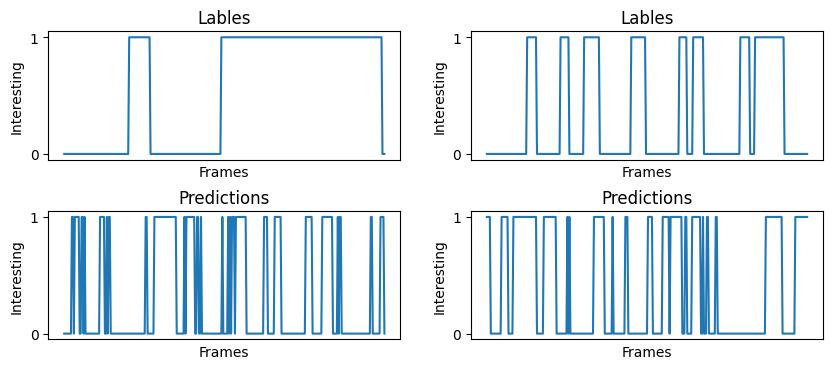

In [23]:
def plots(output_labels):
    fig, ax = plt.subplots(nrows=2, ncols=output_labels.shape[0], figsize=(10,4))
    categories = ['Lables', "Predictions"]
    for row in range(2):
        for col in range(output_labels.shape[0]):
            val = output_labels[col][row]
            ax[row][col].plot(range(len(val)), val.reshape(-1))
            ax[row][col].set_title(categories[row])
            ax[row][col].set_xlabel('Frames')
            ax[row][col].set_ylabel('Interesting')
            ax[row][col].set_yticks([0, 1])
            ax[row][col].set_xticks([])
    plt.subplots_adjust(hspace=0.4)

num_videos = 2
p = np.random.choice(output_labels.shape[0], size=num_videos, replace=False)
plots(output_labels[p])

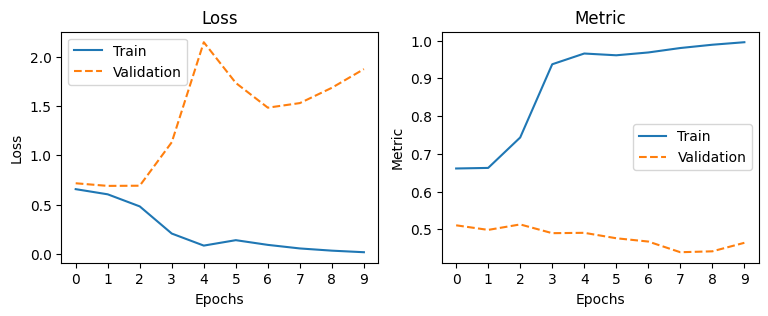

In [24]:
def get_loss_metrics_plots(losses_metrics):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
    titles = ['Loss', 'Metric']
    for col in range(2):
        train_vals = losses_metrics[col]['train']
        val_vals = losses_metrics[col]['val']

        ax[col].plot(range(len(train_vals)), train_vals, label='Train')
        ax[col].plot(range(len(val_vals)), val_vals, label='Validation', linestyle='--')

        ax[col].set_title(titles[col])
        ax[col].set_xlabel('Epochs')
        ax[col].set_ylabel(titles[col])
        ax[col].set_xticks(range(len(train_vals)))
        ax[col].legend()
            
losses_metrics = [loss_history, metric_history]
get_loss_metrics_plots(losses_metrics)

In [25]:
from predictions import VideoTrimmer

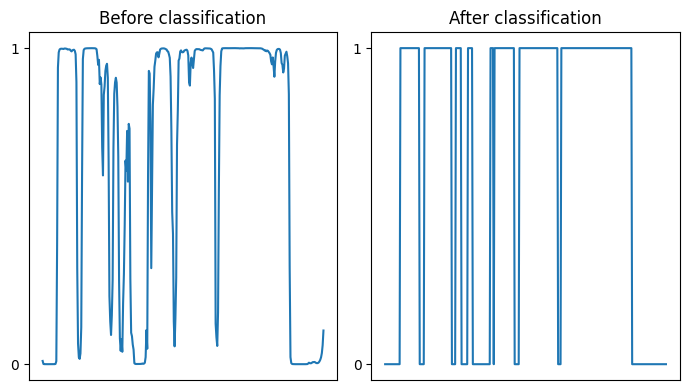

MoviePy - Building video c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_73.04-102.44.mp4.
MoviePy - Writing audio in 0uOkigs9hnY_73.04-102.44TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_73.04-102.44.mp4



MoviePy - Done !
MoviePy - video ready c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_73.04-102.44.mp4
MoviePy - Building video c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_55.66-71.67.mp4.
MoviePy - Writing audio in 0uOkigs9hnY_55.66-71.67TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_55.66-71.67.mp4



MoviePy - Done !
MoviePy - video ready c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_55.66-71.67.mp4
MoviePy - Building video c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_16.22-27.56.mp4.
MoviePy - Writing audio in 0uOkigs9hnY_16.22-27.56TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_16.22-27.56.mp4



MoviePy - Done !
MoviePy - video ready c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_16.22-27.56.mp4
MoviePy - Building video c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_44.18-54.18.mp4.
MoviePy - Writing audio in 0uOkigs9hnY_44.18-54.18TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_44.18-54.18.mp4



MoviePy - Done !
MoviePy - video ready c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_44.18-54.18.mp4
MoviePy - Building video c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_0.00-14.86.mp4.
MoviePy - Writing audio in 0uOkigs9hnY_0.00-14.86TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_0.00-14.86.mp4



MoviePy - Done !
MoviePy - video ready c:\Users\solov\CodeProjects\clips_project\data\trimmed\0uOkigs9hnY_0.00-14.86.mp4


KeyboardInterrupt: 

In [26]:
# 0uOkigs9hnY

# jppL6HfDC0s
# mdnF9R-Bzpg
# 4VtHiSE-w3M
# S8b55wS7ax8
# 31pdm7lxe1c
# OQnQo6qwN0A
# aSGvZceuD5s
# JRAdnd3ORXM
# Sis_JJZoAfQ
# ZengOKCUBHo
# eLPkIwbXTdI
# mOwGBeS5QzM
# _GoVK5yQ2-A
# WUS37tJ1J5c

video_folder = os.path.join(os.getcwd(), 'data', 'videos')
output_folder = os.path.join(os.getcwd(), 'data', 'trimmed')
model_name = 'new'

trimmer = VideoTrimmer(video_folder, output_folder, model_name)    
trimmer.predict_trimmed('0uOkigs9hnY', 5)
trimmer.predict_trimmed('nikita', 5)